<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/foundation/transformers-fine-tuning-yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers fine tuning on YELP for sentiment

* Derived from: https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/tensorflow/training.ipynb#
* https://huggingface.co/transformers/training.html
  * https://huggingface.co/transformers/training.html#fine-tuning-with-keras
* https://huggingface.co/datasets/yelp_review_full
  * https://huggingface.co/docs/datasets/
    * https://github.com/huggingface/datasets


## Installation

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.8.0'

In [4]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi

Tue Apr 26 15:25:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# https://huggingface.co/transformers/installation.html
# !pip install -q transformers 

In [7]:
# https://huggingface.co/docs/datasets/installation.html
# !pip install -q datasets

In [8]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 325 kB 66.6 MB/s 
     |████████████████████████████████| 6.6 MB 35.1 MB/s 
     |████████████████████████████████| 596 kB 52.4 MB/s 
     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 895 kB 53.1 MB/s 
     |████████████████████████████████| 1.1 MB 51.5 MB/s 
     |████████████████████████████████| 212 kB 19.1 MB/s 
     |████████████████████████████████| 136 kB 40.2 MB/s 
     |████████████████████████████████| 127 kB 62.2 MB/s 
     |████████████████████████████████| 271 kB 56.6 MB/s 
     |████████████████████████████████| 144 kB 57.4 MB/s 
     |████████████████████████████████| 94 kB 1.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

# Fine-tune a pretrained model

There are significant benefits to using a pretrained model. It reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch. 🤗 Transformers provides access to thousands of pretrained models for a wide range of tasks. When you use a pretrained model, you train it on a dataset specific to your task. This is known as fine-tuning, an incredibly powerful training technique. In this tutorial, you will fine-tune a pretrained model with a deep learning framework of your choice:

* Fine-tune a pretrained model with 🤗 Transformers [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer).
* Fine-tune a pretrained model in TensorFlow with Keras.
* Fine-tune a pretrained model in native PyTorch.

<a id='data-processing'></a>

## Prepare a dataset

In [9]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_BZearw7f0w?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

Before you can fine-tune a pretrained model, download a dataset and prepare it for training. The previous tutorial showed you how to process data for training, and now you get an opportunity to put those skills to the test!

Begin by loading the [Yelp Reviews](https://huggingface.co/datasets/yelp_review_full) dataset:

In [10]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")
dataset["train"][100]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

As you now know, you need a tokenizer to process the text and include a padding and truncation strategy to handle any variable sequence lengths. To process your dataset in one step, use 🤗 Datasets [`map`](https://huggingface.co/docs/datasets/process.html#map) method to apply a preprocessing function over the entire dataset:

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

  0%|          | 0/650 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

If you like, you can create a smaller subset of the full dataset to fine-tune on to reduce the time it takes:

In [12]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

<a id='trainer'></a>

## Train

<a id='keras'></a>

In [13]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/rnTGBy2ax1c?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

🤗 Transformers models also supports training in TensorFlow with the Keras API.

### Convert dataset to TensorFlow format

The [DefaultDataCollator](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DefaultDataCollator) assembles tensors into a batch for the model to train on. Make sure you specify `return_tensors` to return TensorFlow tensors:

In [14]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

<Tip>

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) uses [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding) by default so you don't need to explicitly specify a data collator.

</Tip>

Next, convert the tokenized datasets to TensorFlow datasets with the [`to_tf_dataset`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.to_tf_dataset) method. Specify your inputs in `columns`, and your label in `label_cols`:

In [15]:
tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = small_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

### Compile and fit

Load a TensorFlow model with the expected number of labels:

In [16]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then compile and fine-tune your model with [`fit`](https://keras.io/api/models/model_training_apis/) as you would with any other Keras model:

In [17]:
%%time

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=10)

Epoch 1/10
125/125 [==============================] - 171s 1s/step - loss: 1.5625 - sparse_categorical_accuracy: 0.2640 - val_loss: 1.3266 - val_sparse_categorical_accuracy: 0.4080
Epoch 2/10
125/125 [==============================] - 156s 1s/step - loss: 1.1624 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.2633 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/10
125/125 [==============================] - 157s 1s/step - loss: 0.9470 - sparse_categorical_accuracy: 0.5780 - val_loss: 1.1040 - val_sparse_categorical_accuracy: 0.4950
Epoch 4/10
125/125 [==============================] - 158s 1s/step - loss: 0.7322 - sparse_categorical_accuracy: 0.6880 - val_loss: 1.3420 - val_sparse_categorical_accuracy: 0.4690
Epoch 5/10
125/125 [==============================] - 161s 1s/step - loss: 0.5790 - sparse_categorical_accuracy: 0.7510 - val_loss: 1.1764 - val_sparse_categorical_accuracy: 0.5540
Epoch 6/10
125/125 [==============================] - 162s 1s/step - loss: 0.4557 - sparse_cate

<a id='pytorch_native'></a>

In [18]:
model.evaluate(tf_train_dataset)

125/125 [==============================] - 44s 333ms/step - loss: 0.0926 - sparse_categorical_accuracy: 0.9720


[0.09261258691549301, 0.972000002861023]

In [19]:
# training data set too small to not overfit on it
model.evaluate(tf_validation_dataset)

125/125 [==============================] - 41s 324ms/step - loss: 1.6995 - sparse_categorical_accuracy: 0.5290


[1.6995238065719604, 0.5289999842643738]

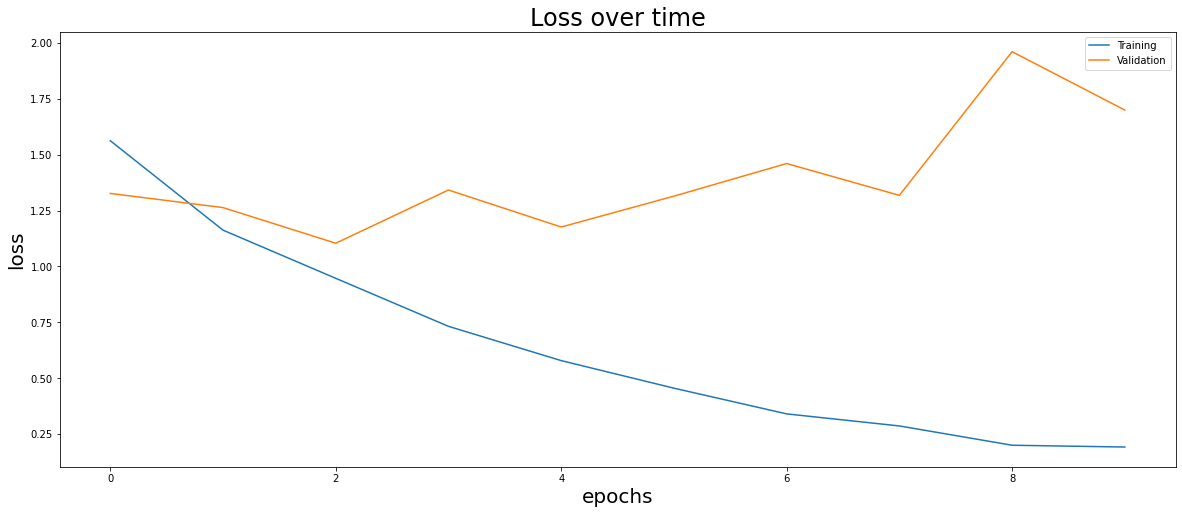

In [20]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

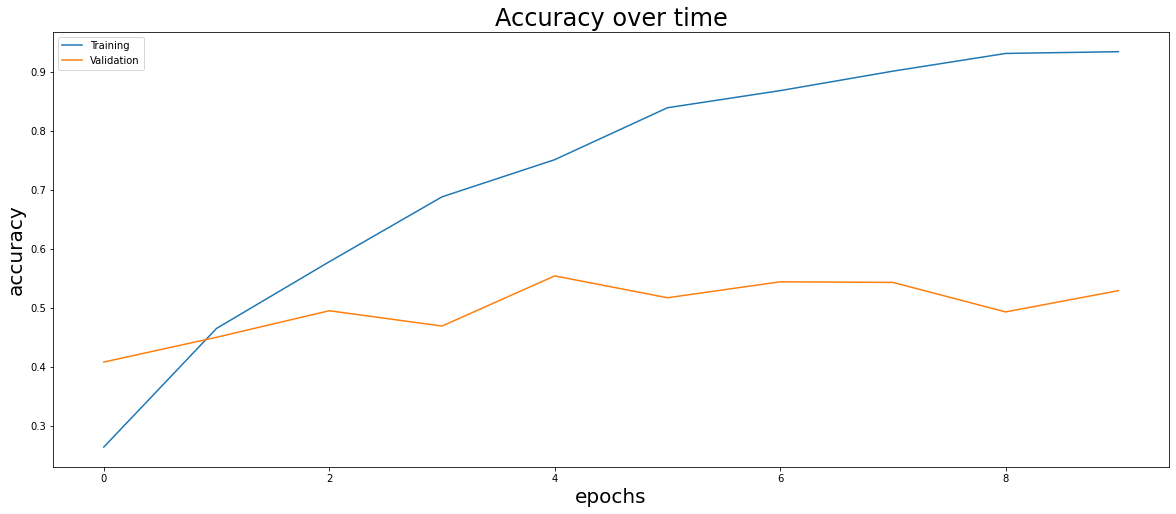

In [21]:
# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['sparse_categorical_accuracy']);
plt.plot(history.history['val_sparse_categorical_accuracy']);

plt.legend(['Training', 'Validation']);


## Trying out the trained model

In [31]:
sequence_0 = "I don't think its a good idea to have people driving 40 miles an hour through a light that *just* turned green, especially with the number of people running red lights, or the number of pedestrians running across at the last minute being obscured by large cars in the lanes next to you."
sequence_1 = 'MANY YEARS ago, When I was a teenager, I delivered pizza. I had a friend who, just for the fun of it, had a CB. While on a particular channel, he could key the mike with quick taps and make the light right out in front of the pizza place turn green. It was the only light that it worked on, and I was in the car with him numerous times to confirm that it worked. It was sweet.'
sequence_2 = 'The "green" thing to do is not to do anything ever, don\'t even breath!  Oh, and if you are not going to take that ridiculous standpoint then I guess this is relevant to Green because it uses Bio-fuels in one of the most harsh environments in the world, showing that dependence on tradition fuels is a choice not a necessity.'

In [39]:
paraphrase = tokenizer(sequence_0, return_tensors="tf")
# paraphrase = tokenizer(sequence_1, return_tensors="tf")
# paraphrase = tokenizer(sequence_2, return_tensors="tf")

paraphrase_classification_logits = model(paraphrase)[0]
paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]
stars = paraphrase_results.argmax() + 1
paraphrase_classification_logits, paraphrase_results, stars

(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.9569411,  4.4531918,  0.7011591, -1.2159353, -3.0617037]],
       dtype=float32)>,
 array([4.3326737e-03, 9.6905154e-01, 2.2743627e-02, 3.3440772e-03,
        5.2804290e-04], dtype=float32),
 2)

In [38]:
# paraphrase = tokenizer(sequence_0, return_tensors="tf")
paraphrase = tokenizer(sequence_1, return_tensors="tf")
# paraphrase = tokenizer(sequence_2, return_tensors="tf")

paraphrase_classification_logits = model(paraphrase)[0]
paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]
stars = paraphrase_results.argmax() + 1
paraphrase_classification_logits, paraphrase_results, stars

(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-2.919123  , -2.9158864 ,  0.43707752,  4.7926683 ,  0.9579457 ]],
       dtype=float32)>,
 array([4.3224433e-04, 4.3364541e-04, 1.2396770e-02, 9.6586758e-01,
        2.0869823e-02], dtype=float32),
 4)

In [37]:
# paraphrase = tokenizer(sequence_0, return_tensors="tf")
# paraphrase = tokenizer(sequence_1, return_tensors="tf")
paraphrase = tokenizer(sequence_2, return_tensors="tf")

paraphrase_classification_logits = model(paraphrase)[0]
paraphrase_results = tf.nn.softmax(paraphrase_classification_logits, axis=1).numpy()[0]
stars = paraphrase_results.argmax() + 1
paraphrase_classification_logits, paraphrase_results, stars

(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 3.8597357,  1.0713259, -2.3566697, -2.0985963, -1.2147253]],
       dtype=float32)>,
 array([0.9325278 , 0.05736815, 0.00186171, 0.00240986, 0.00583246],
       dtype=float32),
 1)

## Additional resources

For more fine-tuning examples, refer to:

- [🤗 Transformers Examples](https://github.com/huggingface/transformers/tree/main/examples) includes scripts
  to train common NLP tasks in PyTorch and TensorFlow.

- [🤗 Transformers Notebooks](https://huggingface.co/docs/transformers/main/en/notebooks) contains various notebooks on how to fine-tune a model for specific tasks in PyTorch and TensorFlow.